In [1]:
from __future__ import (division, print_function, absolute_import)

In [2]:
%matplotlib inline
import math
import matplotlib.pyplot as plt 
import numpy as np
import healpy as hp
import pyfits as pf
import astropy as ap
import os
from scipy.special import eval_legendre  ##special scipy function

In [3]:
# Pixel 42 : [ 0.612372, 0.612372, 0.500000 ]
# Pixel 57 : [ 0.783917, 0.523797, 0.333333 ]
# Pixel 58 : [ 0.523797, 0.783917, 0.333333 ]
# Pixel 74 : [ 0.697217, 0.697217, 0.166667 ]

In [4]:
#
# We define this pixel patch
#
# Note: We have to put into IDL format for 3D vectors, i.e. 
# HDIL> query_polygon, 512L, [[0.612372, 0.783917, 0.523797, 0.697217], 
#       [0.612372, 0.523797, 0.783917, 0.697217], [0.500000, 0.333333, 0.333333, 0.166667]], listpix3, nlist3
#

In [5]:
#
# Now, save IDL .sav file of listpix3
# Import into Python and run
#

In [6]:
# http://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.io.readsav.html
# http://www.astrobetter.com/blog/2009/11/24/read-idl-save-files-into-python/

In [7]:
import scipy

In [8]:
#
# scipy.io.readsav
#
# scipy.io.readsav(file_name, idict=None, python_dict=False, uncompressed_file_name=None, verbose=False)[source]
#
# Read an IDL .sav file
#
#

In [9]:
cd ~/Downloads

/Users/evanbiederstedt/Downloads


In [10]:
import scipy.io

In [11]:
patch_file = scipy.io.readsav('patch_listpix5.sav')

In [12]:
type(patch_file)

scipy.io.idl.AttrDict

In [13]:
arr3 = patch_file['listpix5']
#print(arr3)

In [14]:
type(arr3)

numpy.ndarray

In [15]:
print(len(arr3)) # pixels total 12476

768


In [16]:
camb_map512 = "camb_map_nside512.fits"

In [17]:
camb_map512

'camb_map_nside512.fits'

In [18]:
nside=512
npix = 12*(nside**2) #total number of pixels, npix
LMAX = ((2*nside)) #maximum l of the power spectrum C_l
heal_npix = hp.nside2npix(nside) # Healpix calculated npix

print("The total number of pixels is " + str(npix))
print("The maximum ell of the power spectrum C_l set to lmax = 2*nside " +str(LMAX))
print("Healpix tells me total number of pixels npix is equal to " + str(heal_npix))

The total number of pixels is 3145728
The maximum ell of the power spectrum C_l set to lmax = 2*nside 1024
Healpix tells me total number of pixels npix is equal to 3145728


In [19]:
mapread_camb512 = hp.read_map(camb_map512)
#hp.mollview(mapread_camb512)

NSIDE = 512
ORDERING = RING in fits file


In [20]:
# rename array for convenience
tempval = mapread_camb512
#print tempval

# Data:
#     tempval      # the array of pixel values, (3145728,)

In [21]:
print(len(tempval))
print(tempval.shape)

3145728
(3145728,)


In [22]:
#
# We only wish to use the pixels defined in our patch
# These pixel indices are listed in arr3 such that total number pixels total 12476
#
# arr3: this defines pixel indices within patch
# 
# To access pixel indices within array of CMB pixels, just use tempval[arr3]
#
patch=tempval[arr3]

In [23]:
print(len(patch))

768


In [24]:
# The log-likelihood
#
# -2lnL \propto m^T C^-1 m + ln det C + N ln (2pi)
#
# First term, m^T C^-1 m is the "model fit term"
# Second term, lndetC is the "complexity penalty"
# Third term, N ln 2pi, a constant
#
# m = tempval
# C = Sij

In [25]:
m = patch


In [26]:
# Next, create the matrix, n_i /cdot n_j
# solely using Healpy routines, i.e. taking the dot product of the vectors
# The result is "dotproductmatrix"

In [27]:
npix

3145728

In [28]:
nside

512

In [29]:
## healpy.pixelfunc.pix2vec(nside, ipix, nest=False)
## 
## will give three arrays
## arrays of all x values, all y values, all z values
## RING scheme default
# len()=3
# type()=tuple

In [30]:
vecval = hp.pix2vec(nside, arr3) #Nside = 512, type()=tuple

In [31]:
len(vecval)

3

In [32]:
vecvalx = vecval[0] #len() = 12476
vecvaly = vecval[1]
vecvalz = vecval[2]

In [33]:
# First arrange arrays vertically
# numpy.vstack = Stack arrays in sequence vertically (row wise), input sequence of arrays
totalvecval = np.vstack((vecvalx, vecvaly, vecvalz)) #type()=numpy.ndarray

In [34]:
trans = totalvecval.T #transpose


In [35]:
dotproductmatrix = trans.dot(totalvecval) #take the dot product
print(dotproductmatrix.shape) # = (npix, npix) = (12476, 12476)
# type(dotproductmatrix) = np.ndarray

(768, 768)


In [36]:
#
# The following procedure is for the angular power spectrum, C^th_ell
# However, we are using some cosmological parameter, /alpha
#
#
# =========================================================
# =========================================================
#
# \Sum_l (2*l + 1)/4pi C^th_l P_l (dotproductmatrix)
# sum from l=2 to l=lmax
#
# arrays l = [2 3 4 .... lmax]
#        C_l = [C_2 C_3 .... C_lmax]
#
# The correct way to do the summation:
# 
# Step 1: calculate the matrix
#            M = dotproductmatrix
#
# Step 2: evaluate the function P_l(x) for each entry of the matrix
#         OUTPUT: [P_2(M) P_3(M) P_4(M) .... P_lmax(M) ]
#
# Step 3: (2*l +1)/4pi from l=2 to l=lmax
#          [5/4pi 7/4pi 9/4pi 11/4pi .... 65/4pi ]
#
# Step 4: multiply 
#         [5/4pi*P_2(M) + 7/4pi*P_3(M) +...... + 65/4pi*P_32(M)]
#
#
# Step 5: multiply by theoretical CAMB values, [C_2 C_3    C_31 C_32]
#         [5/4pi**C_2* P_2(M) + 7/4pi*C_3* P_3(M) +...... + 65/4pi*C_32* P_32(M)]
#
# Step 6: This is an array of S_ij for each theory C_l, l=2 to l=32
#         
#
#
# =========================================================
# =========================================================

In [37]:
#print(dotproductmatrix)

In [38]:
#
# Let's first just take l_max = nside
# so, that's lmax = 512
#

In [39]:
# For lmax = 512, we must create an array of ell values, i.e. [0 1 2 3....31 32]
ell = np.arange(513)
#print(ell)
# 
# Subtract the monopole and dipole, l=0, l=1
ellval = ell[2:]
#print(ellval)


In [40]:
# The correct way to do the summation:
# 
# Step 1: calculate the matrix
#            M = dotproductmatrix
#
# Step 2: evaluate the function P_l(x) for each entry of the matrix
#         OUTPUT: [P_2(M) P_3(M) P_4(M) .... P_lmax(M) ]
#
# Step 3: (2*l +1)/4pi from l=2 to l=lmax
#          [5/4pi 7/4pi 9/4pi 11/4pi .... 65/4pi ]
#
# Step 4: multiply 
#         [5/4pi*P_2(M) + 7/4pi*P_3(M) +...... + 65/4pi*P_32(M)]
#
#
# Step 5: multiply by theoretical CAMB values, [C_2 C_3    C_31 C_32]
#         [5/4pi**C_2* P_2(M) + 7/4pi*C_3* P_3(M) +...... + 65/4pi*C_32* P_32(M)]
#
# Step 6: This is an array of S_ij for each theory C_l, l=2 to l=32
#         

In [41]:
dotproductmatrix.shape

(768, 768)

In [42]:
# Step 1: calculate the matrix
M = dotproductmatrix

In [43]:
# Step 2: evaluate the function P_l(x) for each entry of the matrix
#         OUTPUT: [P_2(M) P_3(M) P_4(M) .... P_lmax(M) ]


In [44]:
# CODE BOTTLENECK!
# 
# Evaluate Legendre from l=2 to l=lmax for each matrix entry
# [P_2(M) P_3(M) P_4(M) .... P_lmax(M) ]
# 
# WITHOUT BROADCASTING, one would do something like 
# PlMat = []
# for i in ellval:
#    PlMat.append( eval_legendre(i, dotproductmatrix) )
#
#
# With broadcasting, we use
# PlMat = eval_legendre(ellval[:, None, None], dotproductmatrix)
# PlMat = [P_2(M) P_3(M) P_4(M) .... P_lmax(M) ]
# PlMat is an array, len()=31 of 31 3072 by 3072 matrices
# PlMat.shape = (31, 3072, 3072)

In [45]:
#This doesn't run for lmax=512
#So, split 'ellval' into ten arrays and then sum afterwards

splitell = np.array_split(ellval, 150)
splitell[0]

array([2, 3, 4, 5])

In [46]:
PlMat1 = eval_legendre(splitell[0][:, None, None], dotproductmatrix)

In [47]:
PlMat2 = eval_legendre(splitell[1][:, None, None], dotproductmatrix)

In [48]:
PlMat3 = eval_legendre(splitell[2][:, None, None], dotproductmatrix)

In [49]:
PlMat4 = eval_legendre(splitell[3][:, None, None], dotproductmatrix)

In [50]:
PlMat5 = eval_legendre(splitell[4][:, None, None], dotproductmatrix)

In [51]:
PlMat6 = eval_legendre(splitell[5][:, None, None], dotproductmatrix)

In [52]:
PlMat7 = eval_legendre(splitell[6][:, None, None], dotproductmatrix)

In [53]:
PlMat8 = eval_legendre(splitell[7][:, None, None], dotproductmatrix)

In [54]:
PlMat9 = eval_legendre(splitell[8][:, None, None], dotproductmatrix)

In [55]:
PlMat10 = eval_legendre(splitell[9][:, None, None], dotproductmatrix)

In [56]:
PlMat11 = eval_legendre(splitell[10][:, None, None], dotproductmatrix)

In [57]:
PlMat12 = eval_legendre(splitell[11][:, None, None], dotproductmatrix)

In [58]:
PlMat13 = eval_legendre(splitell[12][:, None, None], dotproductmatrix)

In [59]:
PlMat14 = eval_legendre(splitell[13][:, None, None], dotproductmatrix)

In [60]:
PlMat15 = eval_legendre(splitell[14][:, None, None], dotproductmatrix)

In [61]:
PlMat16 = eval_legendre(splitell[15][:, None, None], dotproductmatrix)

In [62]:
PlMat17 = eval_legendre(splitell[16][:, None, None], dotproductmatrix)

In [63]:
PlMat18 = eval_legendre(splitell[17][:, None, None], dotproductmatrix)

In [64]:
PlMat19 = eval_legendre(splitell[18][:, None, None], dotproductmatrix)

In [65]:
PlMat20 = eval_legendre(splitell[19][:, None, None], dotproductmatrix)

In [66]:
PlMat21 = eval_legendre(splitell[20][:, None, None], dotproductmatrix)

In [67]:
PlMat22 = eval_legendre(splitell[21][:, None, None], dotproductmatrix)

In [68]:
PlMat23 = eval_legendre(splitell[22][:, None, None], dotproductmatrix)

In [69]:
PlMat24 = eval_legendre(splitell[23][:, None, None], dotproductmatrix)

In [70]:
PlMat25 = eval_legendre(splitell[24][:, None, None], dotproductmatrix)

In [71]:
PlMat26 = eval_legendre(splitell[25][:, None, None], dotproductmatrix)

In [72]:
PlMat27 = eval_legendre(splitell[26][:, None, None], dotproductmatrix)

In [73]:
PlMat28 = eval_legendre(splitell[27][:, None, None], dotproductmatrix)

In [74]:
PlMat29 = eval_legendre(splitell[28][:, None, None], dotproductmatrix)

In [75]:
PlMat30 = eval_legendre(splitell[29][:, None, None], dotproductmatrix)

In [76]:
PlMat31 = eval_legendre(splitell[30][:, None, None], dotproductmatrix)

In [77]:
PlMat32 = eval_legendre(splitell[31][:, None, None], dotproductmatrix)

In [78]:
PlMat33 = eval_legendre(splitell[32][:, None, None], dotproductmatrix)

In [79]:
PlMat34 = eval_legendre(splitell[33][:, None, None], dotproductmatrix)

In [80]:
PlMat35 = eval_legendre(splitell[34][:, None, None], dotproductmatrix)

In [81]:
PlMat36 = eval_legendre(splitell[35][:, None, None], dotproductmatrix)

In [82]:
PlMat37 = eval_legendre(splitell[36][:, None, None], dotproductmatrix)

In [83]:
PlMat38 = eval_legendre(splitell[37][:, None, None], dotproductmatrix)

In [84]:
PlMat39 = eval_legendre(splitell[38][:, None, None], dotproductmatrix)

In [85]:
PlMat40 = eval_legendre(splitell[39][:, None, None], dotproductmatrix)

In [86]:
PlMat41 = eval_legendre(splitell[40][:, None, None], dotproductmatrix)

In [87]:
PlMat42 = eval_legendre(splitell[41][:, None, None], dotproductmatrix)

In [88]:
PlMat43 = eval_legendre(splitell[42][:, None, None], dotproductmatrix)

In [89]:
PlMat44 = eval_legendre(splitell[43][:, None, None], dotproductmatrix)

In [90]:
PlMat45 = eval_legendre(splitell[44][:, None, None], dotproductmatrix)

In [91]:
PlMat46 = eval_legendre(splitell[45][:, None, None], dotproductmatrix)

In [92]:
PlMat47 = eval_legendre(splitell[46][:, None, None], dotproductmatrix)

In [93]:
PlMat48 = eval_legendre(splitell[47][:, None, None], dotproductmatrix)

In [94]:
PlMat49 = eval_legendre(splitell[48][:, None, None], dotproductmatrix)

In [95]:
PlMat50 = eval_legendre(splitell[49][:, None, None], dotproductmatrix)

In [96]:
PlMat51 = eval_legendre(splitell[50][:, None, None], dotproductmatrix)

In [97]:
PlMat52 = eval_legendre(splitell[51][:, None, None], dotproductmatrix)

In [98]:
PlMat53 = eval_legendre(splitell[52][:, None, None], dotproductmatrix)

In [99]:
PlMat54 = eval_legendre(splitell[53][:, None, None], dotproductmatrix)

In [100]:
PlMat55 = eval_legendre(splitell[54][:, None, None], dotproductmatrix)

In [101]:
PlMat56 = eval_legendre(splitell[55][:, None, None], dotproductmatrix)

In [102]:
PlMat57 = eval_legendre(splitell[56][:, None, None], dotproductmatrix)

In [103]:
PlMat58 = eval_legendre(splitell[57][:, None, None], dotproductmatrix)

In [104]:
PlMat59 = eval_legendre(splitell[58][:, None, None], dotproductmatrix)

In [105]:
PlMat60 = eval_legendre(splitell[59][:, None, None], dotproductmatrix)

In [106]:
PlMat61 = eval_legendre(splitell[60][:, None, None], dotproductmatrix)

In [107]:
PlMat62 = eval_legendre(splitell[61][:, None, None], dotproductmatrix)

In [108]:
PlMat63 = eval_legendre(splitell[62][:, None, None], dotproductmatrix)

In [109]:
PlMat64 = eval_legendre(splitell[63][:, None, None], dotproductmatrix)

In [110]:
PlMat65 = eval_legendre(splitell[64][:, None, None], dotproductmatrix)

In [111]:
PlMat66 = eval_legendre(splitell[65][:, None, None], dotproductmatrix)

In [112]:
PlMat67 = eval_legendre(splitell[66][:, None, None], dotproductmatrix)

In [113]:
PlMat68 = eval_legendre(splitell[67][:, None, None], dotproductmatrix)

In [114]:
PlMat69 = eval_legendre(splitell[68][:, None, None], dotproductmatrix)

In [115]:
PlMat70 = eval_legendre(splitell[69][:, None, None], dotproductmatrix)

In [116]:
PlMat71 = eval_legendre(splitell[70][:, None, None], dotproductmatrix)

In [117]:
PlMat72 = eval_legendre(splitell[71][:, None, None], dotproductmatrix)

In [118]:
PlMat73 = eval_legendre(splitell[72][:, None, None], dotproductmatrix)

In [119]:
PlMat74 = eval_legendre(splitell[73][:, None, None], dotproductmatrix)

In [120]:
PlMat75 = eval_legendre(splitell[74][:, None, None], dotproductmatrix)

In [121]:
PlMat76 = eval_legendre(splitell[75][:, None, None], dotproductmatrix)

In [122]:
PlMat77 = eval_legendre(splitell[76][:, None, None], dotproductmatrix)

In [123]:
PlMat78 = eval_legendre(splitell[77][:, None, None], dotproductmatrix)

In [124]:
PlMat79 = eval_legendre(splitell[78][:, None, None], dotproductmatrix)

In [125]:
PlMat80 = eval_legendre(splitell[79][:, None, None], dotproductmatrix)

In [126]:
PlMat81 = eval_legendre(splitell[80][:, None, None], dotproductmatrix)

In [127]:
PlMat82 = eval_legendre(splitell[81][:, None, None], dotproductmatrix)

In [128]:
PlMat83 = eval_legendre(splitell[82][:, None, None], dotproductmatrix)

In [129]:
PlMat84 = eval_legendre(splitell[83][:, None, None], dotproductmatrix)

In [130]:
PlMat85 = eval_legendre(splitell[84][:, None, None], dotproductmatrix)

In [131]:
PlMat86 = eval_legendre(splitell[85][:, None, None], dotproductmatrix)

In [132]:
PlMat87 = eval_legendre(splitell[86][:, None, None], dotproductmatrix)

In [133]:
PlMat88 = eval_legendre(splitell[87][:, None, None], dotproductmatrix)

In [134]:
PlMat89 = eval_legendre(splitell[88][:, None, None], dotproductmatrix)

In [135]:
PlMat90 = eval_legendre(splitell[89][:, None, None], dotproductmatrix)

In [136]:
PlMat91 = eval_legendre(splitell[90][:, None, None], dotproductmatrix)

In [137]:
PlMat92 = eval_legendre(splitell[91][:, None, None], dotproductmatrix)

In [138]:
PlMat93 = eval_legendre(splitell[92][:, None, None], dotproductmatrix)

In [139]:
PlMat94 = eval_legendre(splitell[93][:, None, None], dotproductmatrix)

In [140]:
PlMat95 = eval_legendre(splitell[94][:, None, None], dotproductmatrix)

In [141]:
PlMat96 = eval_legendre(splitell[95][:, None, None], dotproductmatrix)

In [142]:
PlMat97 = eval_legendre(splitell[96][:, None, None], dotproductmatrix)

In [143]:
PlMat98 = eval_legendre(splitell[97][:, None, None], dotproductmatrix)

In [144]:
PlMat99 = eval_legendre(splitell[98][:, None, None], dotproductmatrix)

In [145]:
PlMat100 = eval_legendre(splitell[99][:, None, None], dotproductmatrix)

In [146]:
PlMat101 = eval_legendre(splitell[100][:, None, None], dotproductmatrix)

In [147]:
PlMat102 = eval_legendre(splitell[101][:, None, None], dotproductmatrix)

In [148]:
PlMat103 = eval_legendre(splitell[102][:, None, None], dotproductmatrix)

In [149]:
PlMat104 = eval_legendre(splitell[103][:, None, None], dotproductmatrix)

In [150]:
PlMat105 = eval_legendre(splitell[104][:, None, None], dotproductmatrix)

In [151]:
PlMat106 = eval_legendre(splitell[105][:, None, None], dotproductmatrix)

In [152]:
PlMat107 = eval_legendre(splitell[106][:, None, None], dotproductmatrix)

In [153]:
PlMat108 = eval_legendre(splitell[107][:, None, None], dotproductmatrix)

In [154]:
PlMat109 = eval_legendre(splitell[108][:, None, None], dotproductmatrix)

In [155]:
PlMat110 = eval_legendre(splitell[109][:, None, None], dotproductmatrix)

In [156]:
PlMat111 = eval_legendre(splitell[110][:, None, None], dotproductmatrix)

In [157]:
PlMat112 = eval_legendre(splitell[111][:, None, None], dotproductmatrix)

In [158]:
PlMat113 = eval_legendre(splitell[112][:, None, None], dotproductmatrix)

In [159]:
PlMat114 = eval_legendre(splitell[113][:, None, None], dotproductmatrix)

In [160]:
PlMat115 = eval_legendre(splitell[114][:, None, None], dotproductmatrix)

In [161]:
PlMat116 = eval_legendre(splitell[115][:, None, None], dotproductmatrix)

In [162]:
PlMat117 = eval_legendre(splitell[116][:, None, None], dotproductmatrix)

In [163]:
PlMat118 = eval_legendre(splitell[117][:, None, None], dotproductmatrix)

In [164]:
PlMat119 = eval_legendre(splitell[118][:, None, None], dotproductmatrix)

In [165]:
PlMat120 = eval_legendre(splitell[119][:, None, None], dotproductmatrix)

In [166]:
PlMat121 = eval_legendre(splitell[120][:, None, None], dotproductmatrix)

In [167]:
PlMat122 = eval_legendre(splitell[121][:, None, None], dotproductmatrix)

In [168]:
PlMat123 = eval_legendre(splitell[122][:, None, None], dotproductmatrix)

In [169]:
PlMat124 = eval_legendre(splitell[123][:, None, None], dotproductmatrix)

In [170]:
PlMat125 = eval_legendre(splitell[124][:, None, None], dotproductmatrix)

In [171]:
PlMat126 = eval_legendre(splitell[125][:, None, None], dotproductmatrix)

In [172]:
PlMat127 = eval_legendre(splitell[126][:, None, None], dotproductmatrix)

In [173]:
PlMat128 = eval_legendre(splitell[127][:, None, None], dotproductmatrix)

In [174]:
PlMat129 = eval_legendre(splitell[128][:, None, None], dotproductmatrix)

In [175]:
PlMat130 = eval_legendre(splitell[129][:, None, None], dotproductmatrix)

In [176]:
PlMat131 = eval_legendre(splitell[130][:, None, None], dotproductmatrix)

In [177]:
PlMat132 = eval_legendre(splitell[131][:, None, None], dotproductmatrix)

In [178]:
PlMat133 = eval_legendre(splitell[132][:, None, None], dotproductmatrix)

In [179]:
PlMat134 = eval_legendre(splitell[133][:, None, None], dotproductmatrix)

In [180]:
PlMat135 = eval_legendre(splitell[134][:, None, None], dotproductmatrix)

In [181]:
PlMat136 = eval_legendre(splitell[135][:, None, None], dotproductmatrix)

In [182]:
PlMat137 = eval_legendre(splitell[136][:, None, None], dotproductmatrix)

In [183]:
PlMat138 = eval_legendre(splitell[137][:, None, None], dotproductmatrix)

In [184]:
PlMat139 = eval_legendre(splitell[138][:, None, None], dotproductmatrix)

In [185]:
PlMat140 = eval_legendre(splitell[139][:, None, None], dotproductmatrix)

In [186]:
PlMat141 = eval_legendre(splitell[140][:, None, None], dotproductmatrix)

In [187]:
PlMat142 = eval_legendre(splitell[141][:, None, None], dotproductmatrix)

In [188]:
PlMat143 = eval_legendre(splitell[142][:, None, None], dotproductmatrix)

In [189]:
PlMat144 = eval_legendre(splitell[143][:, None, None], dotproductmatrix)

In [190]:
PlMat145 = eval_legendre(splitell[144][:, None, None], dotproductmatrix)

In [191]:
PlMat146 = eval_legendre(splitell[145][:, None, None], dotproductmatrix)

In [192]:
PlMat147 = eval_legendre(splitell[146][:, None, None], dotproductmatrix)

In [193]:
PlMat148 = eval_legendre(splitell[147][:, None, None], dotproductmatrix)

In [194]:
PlMat149 = eval_legendre(splitell[148][:, None, None], dotproductmatrix)

In [195]:
PlMat150 = eval_legendre(splitell[149][:, None, None], dotproductmatrix)

In [196]:
splitell[49]

array([198, 199, 200, 201])

In [197]:

PlMat_total = np.concatenate((PlMat1, PlMat2, PlMat3, PlMat4, PlMat5, PlMat6, PlMat7, 
                                 PlMat8, PlMat9, PlMat10, PlMat11, PlMat12, PlMat13, PlMat14, PlMat15, 
                                PlMat16, PlMat17, PlMat18, PlMat19, PlMat20, PlMat21, PlMat22, PlMat23, 
                                PlMat24, PlMat25, PlMat26, PlMat27, PlMat28, PlMat29, PlMat30, PlMat31, 
                                PlMat32, PlMat33, PlMat34, PlMat35, PlMat36, PlMat37, PlMat38, PlMat39, 
                                 PlMat40, PlMat41, PlMat42, PlMat43, PlMat44, PlMat45, PlMat46, PlMat47,
                                 PlMat48, PlMat49, PlMat50, PlMat51, PlMat52, PlMat53, PlMat54, PlMat55,
                                 PlMat56, PlMat57, PlMat58, PlMat59, PlMat60, PlMat61, PlMat62, PlMat63,
                                 PlMat64, PlMat65, PlMat66, PlMat67, PlMat68, PlMat69, PlMat70, PlMat71,
                                 PlMat72, PlMat73, PlMat74, PlMat75, PlMat76, PlMat77, PlMat78, PlMat79,
                                 PlMat80, PlMat81, PlMat82, PlMat83, PlMat84, PlMat85, PlMat86, PlMat87,
                                 PlMat88, PlMat89, PlMat90, PlMat91, PlMat92, PlMat93, PlMat94, PlMat95,
                                PlMat96, PlMat97, PlMat98, PlMat99, PlMat100, PlMat101, PlMat102, PlMat103,
                                 PlMat104, PlMat105, PlMat106, PlMat107, PlMat108, PlMat109, PlMat110, PlMat111,
                                 PlMat112, PlMat113, PlMat114, PlMat115, PlMat116, PlMat117, PlMat118, PlMat119,
                                 PlMat120, PlMat121, PlMat122, PlMat123, PlMat124, PlMat125, PlMat126, PlMat127,
                                 PlMat128, PlMat129, PlMat130, PlMat131, PlMat132, PlMat133, PlMat134, PlMat135,
                                  PlMat136, PlMat137, PlMat138, PlMat139, PlMat140, PlMat141, PlMat142, PlMat143,
                                 PlMat144, PlMat145, PlMat146, PlMat147, PlMat148, PlMat149, PlMat150))


In [198]:
PlMat_total.shape

(511, 768, 768)

In [199]:
PlMat = PlMat_total

In [200]:
#import cPickle as pickle

#file_Name = "testfileNov18"
# open the file for writing
#fileObject = open(file_Name,'wb') 

# this writes the object a to the
# file named 'testfile'
#pickle.dump(PlMat_total, fileObject) 

# here we close the fileObject
#fileObject.close()

In [201]:
# Step 3: (2*l +1)/4pi from l=2 to l=lmax
#          [5/4pi 7/4pi 9/4pi 11/4pi .... 65/4pi ]
norm = ((2*ellval + 1))/(4*math.pi)
print(len(ellval))

511


In [202]:

# Step 4: multiply 
#         [5/4pi*P_2(M) + 7/4pi*P_3(M) +...... + 65/4pi*P_32(M)]
#
# multiply PlMat by (2*l+1)/4pi, i.e. norm
norm_matrix = norm[:, None, None] * PlMat
# [5/4pi * P_2(M)  7/4pi * P_3(M) ....   65/4pi * P_32(M)]


In [203]:
norm_matrix.shape

(511, 768, 768)

In [204]:
PlMat.shape

(511, 768, 768)

In [205]:
# Step 5: multiply by theoretical CAMB values, [C_2 C_3    C_31 C_32]
#         [5/4pi**C_2* P_2(M) + 7/4pi*C_3* P_3(M) +...... + 65/4pi*C_32* P_32(M)]

#
# In our case, we use CAMB cosmological parameters
# 
# H_0,  Hubble Constant, 70
#
# Tcmb, 2.7255
#
# Ωbh2, 0.0226
#
# Ωch2, 0.112
#
# Ωνh2, 0.00064, neutrino density
#
# Ωk, 0
#
#The six parameters of the basic ΛCDM model are: the physical baryon density, Ωbh
#2
#; the physical cold dark matter
#density, Ωch
#2
#; the dark energy density, in units of the critical density, ΩΛ; the amplitude of primordial scalar curvature
#perturbations, ∆2
#R at k = 0.002 Mpc−1
#; the power-law spectral index of primordial density (scalar) perturbations,
#ns; and the reionization optical depth, τ . In this model, the Hubble constant, H0 = 100h km/s/Mpc, is implicitly
#determined by the flatness constraint, Ωb + Ωc + ΩΛ = 1. A handful of parameters in this model take assumed values
#that we further test in §4; other parameters may be derived from the fit, as in Table 2. Throughout this paper we
#assume the initial fluctuations are adiabatic and Gaussian distributed (see Bennett et al. (2012) for limits on nonGaussian
#fluctuations from the nine

In [206]:
ones_arr = np.ones(511)

In [207]:
len(ones_arr)

511

In [208]:
Hubble_constant = 70*ones_arr
Baryon_density = (0.0226)*ones_arr
CDM_density = (0.112)*ones_arr

In [209]:
#
# TEST LogLF vs Cosmological parameters
#
# The covariance matrix is a function of variable "Param", an unknown parameter. 
# 
# Our covariance matrix is therefore S_ij  = (2*l +1)/4pi * Param * P_ell(matrix)   
# 
# 
# The LF is then a function of param, LF(param). This is the only parameter we vary. 
#
# LF = -2loglikelihood /propto T^T inv(S_ij) T + log det (Sij) + N log (2pi)
# 
# We then plot LF(x) vs. parameters x. 
#

In [210]:
# define pixel-value arrays
mT = np.matrix(patch)     # mT.shape = (1, 3072)
m = np.matrix(patch).T    # m.shape = (3072, 1)
Npix2pi = (len(patch))*2*math.pi  # LF constant

In [211]:
# baryon density is 0.0226

In [212]:
vary_CDM = np.linspace(0.0050, 0.30, num=20 ) #set default num = 20

In [213]:
vary_CDM

array([ 0.005     ,  0.02052632,  0.03605263,  0.05157895,  0.06710526,
        0.08263158,  0.09815789,  0.11368421,  0.12921053,  0.14473684,
        0.16026316,  0.17578947,  0.19131579,  0.20684211,  0.22236842,
        0.23789474,  0.25342105,  0.26894737,  0.28447368,  0.3       ])

In [214]:
vary_CDM

array([ 0.005     ,  0.02052632,  0.03605263,  0.05157895,  0.06710526,
        0.08263158,  0.09815789,  0.11368421,  0.12921053,  0.14473684,
        0.16026316,  0.17578947,  0.19131579,  0.20684211,  0.22236842,
        0.23789474,  0.25342105,  0.26894737,  0.28447368,  0.3       ])

In [215]:
sigma2 = np.logspace(-12, -14, num=20) #set default num = 30


In [216]:
print(sigma2)

[  1.00000000e-12   7.84759970e-13   6.15848211e-13   4.83293024e-13
   3.79269019e-13   2.97635144e-13   2.33572147e-13   1.83298071e-13
   1.43844989e-13   1.12883789e-13   8.85866790e-14   6.95192796e-14
   5.45559478e-14   4.28133240e-14   3.35981829e-14   2.63665090e-14
   2.06913808e-14   1.62377674e-14   1.27427499e-14   1.00000000e-14]


In [217]:
# For N matrix, set the identity
id_mat = np.identity(768)

In [218]:
noiseresult = sigma2[:, None, None] * id_mat[None, :, :]

In [219]:
noiseresult.shape

(20, 768, 768)

In [220]:
correctmatrix = np.sum(norm_matrix, axis=0)
print(norm_matrix.shape)
print(correctmatrix.shape)

(511, 768, 768)
(768, 768)


In [221]:
tempp = (1e6)*patch # multiply CMB maps by 1e6

def LogLikehood_wNoise_1e12(param, sig):
    # param is our parameter, C_3
    Sij = param[:, None, None] * correctmatrix[None, :, :]
    newSij = (1e12)*Sij   # multiply S_ij by 1e12
    Nij = sig[:, None, None] * id_mat[None, :, :]
    newNij = (1e12)*Nij
    # Format 7/4pi * param * P_3(M) where param is the parameter we vary, C_l
    # Sij.shape = (20, 3072, 3072)
    Cij = newSij + newNij
    #invCij = np.linalg.inv(Cij)
    logdetC = np.linalg.slogdet(Cij)  # returns sign and determinant; use logdetC[1]
    # model_fit_terms = m^T C^-1 m
    #
    # model_fit_terms = np.array([np.dot(tempval.T , np.dot(invCij[i] , tempval) ) 
    # for i in range(invCij.shape[0])])
    #
    model_fit_terms = np.array([np.dot(tempp.T , np.linalg.solve(Cij[i], tempp) ) for i in range(Cij.shape[0]) ]) 
    return model_fit_terms + logdetC[1] + Npix2pi

In [222]:
tempp = (1e6)*patch # multiply CMB maps by 1e6

def LogLikehood_wNoise_1e12_Contour(param, sig):
    # param is our parameter, C_3
    Sij = param * correctmatrix[None, :, :]
    newSij = (1e12)*Sij   # multiply S_ij by 1e12
    Nij = sig * id_mat[None, :, :]
    newNij = (1e12)*Nij
    # Format 7/4pi * param * P_3(M) where param is the parameter we vary, C_l
    # Sij.shape = (20, 3072, 3072)
    Cij = newSij + newNij
    #invCij = np.linalg.inv(Cij)
    logdetC = np.linalg.slogdet(Cij)  # returns sign and determinant; use logdetC[1]
    # model_fit_terms = m^T C^-1 m
    #
    # model_fit_terms = np.array([np.dot(tempval.T , np.dot(invCij[i] , tempval) ) 
    # for i in range(invCij.shape[0])])
    #
    model_fit_terms = np.array([np.dot(tempp.T , np.linalg.solve(Cij[i], tempp) ) for i in range(Cij.shape[0]) ]) 
    return model_fit_terms + logdetC[1] + Npix2pi

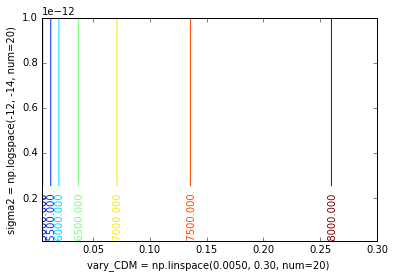

In [223]:
import pylab as pb    
import matplotlib.pyplot as plt 

vary_CDM = np.linspace(0.0050, 0.30, num=20) #set default num = 20
sigma2 = np.logspace(-12, -14, num=20) #set default num = 30

xxx = vary_CDM
yyy = sigma2

zzz = np.array([[LogLikehood_wNoise_1e12_Contour(np.asarray(i), np.asarray(j)) for i in xxx] for j in yyy])

zzzreshaped = zzz.reshape(20,20)

plt.figure()
CS = plt.contour(xxx, yyy, zzzreshaped)
plt.clabel(CS, inline=1, fontsize=10)
plt.xlabel("vary_CDM = np.linspace(0.0050, 0.30, num=20) ")
plt.ylabel("sigma2 = np.logspace(-12, -14, num=20)")
pb.show()

In [224]:
patch[:15]

array([ -2.11592887e-05,  -2.23534971e-05,  -2.16956214e-05,
        -2.35519983e-05,  -2.28862627e-05,  -2.22507078e-05,
        -2.47526477e-05,  -2.40813188e-05,  -2.34372274e-05,
        -2.28231584e-05,  -2.59533390e-05,  -2.52786413e-05,
        -2.46282743e-05,  -2.40050049e-05,  -2.34115760e-05])

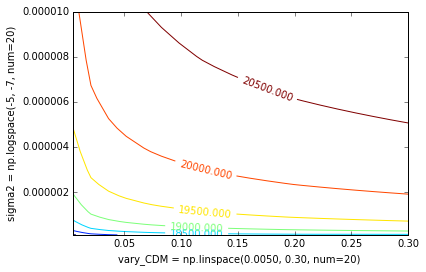

In [225]:
vary_CDM = np.linspace(0.0050, 0.30, num=20) #set default num = 20
sigma2 = np.logspace(-5, -7, num=20) #set default num = 30

xxx = vary_CDM
yyy = sigma2

zzz = np.array([[LogLikehood_wNoise_1e12_Contour(np.asarray(i), np.asarray(j)) for i in xxx] for j in yyy])

zzzreshaped = zzz.reshape(20,20)

plt.figure()
CS = plt.contour(xxx, yyy, zzzreshaped)
plt.clabel(CS, inline=1, fontsize=10)
plt.xlabel("vary_CDM = np.linspace(0.0050, 0.30, num=20) ")
plt.ylabel("sigma2 = np.logspace(-5, -7, num=20)")
pb.show()

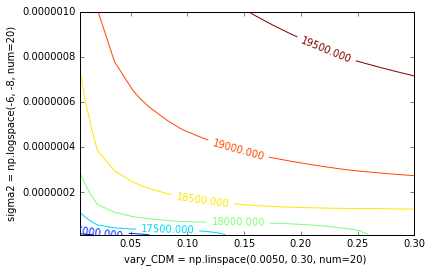

In [226]:
vary_CDM = np.linspace(0.0050, 0.30, num=20 ) #set default num = 20
sigma2 = np.logspace(-6, -8, num=20) #set default num = 30

xxx = vary_CDM
yyy = sigma2

zzz = np.array([[LogLikehood_wNoise_1e12_Contour(np.asarray(i), np.asarray(j)) for i in xxx] for j in yyy])

zzzreshaped = zzz.reshape(20,20)

plt.figure()
CS = plt.contour(xxx, yyy, zzzreshaped)
plt.clabel(CS, inline=1, fontsize=10)
plt.xlabel("vary_CDM = np.linspace(0.0050, 0.30, num=20) ")
plt.ylabel("sigma2 = np.logspace(-6, -8, num=20)")
pb.show()

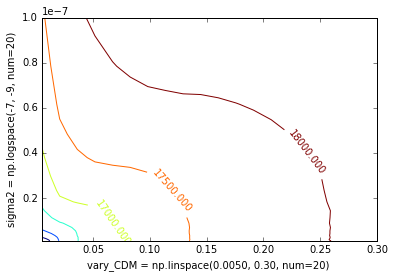

In [227]:
vary_CDM = np.linspace(0.0050, 0.30, num=20 ) #set default num = 20
sigma2 = np.logspace(-7, -9, num=20) #set default num = 30

xxx = vary_CDM
yyy = sigma2

zzz = np.array([[LogLikehood_wNoise_1e12_Contour(np.asarray(i), np.asarray(j)) for i in xxx] for j in yyy])

zzzreshaped = zzz.reshape(20,20)

plt.figure()
CS = plt.contour(xxx, yyy, zzzreshaped)
plt.clabel(CS, inline=1, fontsize=10)
plt.xlabel("vary_CDM = np.linspace(0.0050, 0.30, num=20) ")
plt.ylabel("sigma2 = np.logspace(-7, -9, num=20)")
pb.show()

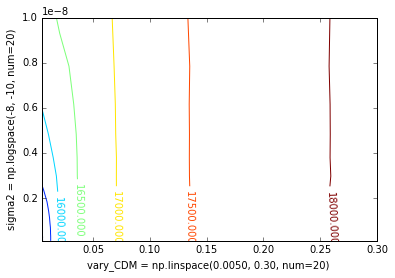

In [228]:
vary_CDM = np.linspace(0.0050, 0.30, num=20 ) #set default num = 20
sigma2 = np.logspace(-8, -10, num=20) #set default num = 30

xxx = vary_CDM
yyy = sigma2

zzz = np.array([[LogLikehood_wNoise_1e12_Contour(np.asarray(i), np.asarray(j)) for i in xxx] for j in yyy])

zzzreshaped = zzz.reshape(20,20)

plt.figure()
CS = plt.contour(xxx, yyy, zzzreshaped)
plt.clabel(CS, inline=1, fontsize=10)
plt.xlabel("vary_CDM = np.linspace(0.0050, 0.30, num=20) ")
plt.ylabel("sigma2 = np.logspace(-8, -10, num=20)")
pb.show()

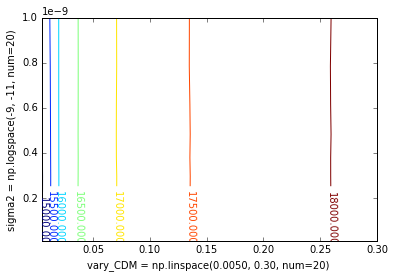

In [229]:
vary_CDM = np.linspace(0.0050, 0.30, num=20 ) #set default num = 20
sigma2 = np.logspace(-9, -11, num=20) #set default num = 30

xxx = vary_CDM
yyy = sigma2

zzz = np.array([[LogLikehood_wNoise_1e12_Contour(np.asarray(i), np.asarray(j)) for i in xxx] for j in yyy])

zzzreshaped = zzz.reshape(20,20)

plt.figure()
CS = plt.contour(xxx, yyy, zzzreshaped)
plt.clabel(CS, inline=1, fontsize=10)
plt.xlabel("vary_CDM = np.linspace(0.0050, 0.30, num=20) ")
plt.ylabel("sigma2 = np.logspace(-9, -11, num=20)")
pb.show()

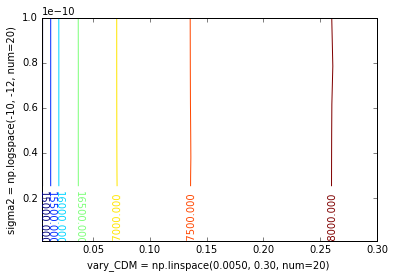

In [230]:
vary_CDM = np.linspace(0.0050, 0.30, num=20 ) #set default num = 20
sigma2 = np.logspace(-10, -12, num=20) #set default num = 30

xxx = vary_CDM
yyy = sigma2

zzz = np.array([[LogLikehood_wNoise_1e12_Contour(np.asarray(i), np.asarray(j)) for i in xxx] for j in yyy])

zzzreshaped = zzz.reshape(20,20)

plt.figure()
CS = plt.contour(xxx, yyy, zzzreshaped)
plt.clabel(CS, inline=1, fontsize=10)
plt.xlabel("vary_CDM = np.linspace(0.0050, 0.30, num=20) ")
plt.ylabel("sigma2 = np.logspace(-10, -12, num=20)")
pb.show()

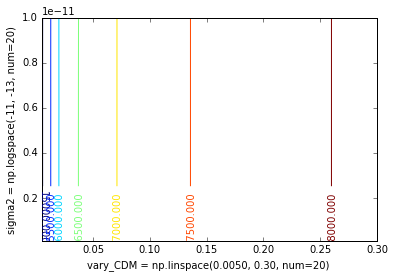

In [231]:
vary_CDM = np.linspace(0.0050, 0.30, num=20 ) #set default num = 20
sigma2 = np.logspace(-11, -13, num=20) #set default num = 30

xxx = vary_CDM
yyy = sigma2

zzz = np.array([[LogLikehood_wNoise_1e12_Contour(np.asarray(i), np.asarray(j)) for i in xxx] for j in yyy])

zzzreshaped = zzz.reshape(20,20)

plt.figure()
CS = plt.contour(xxx, yyy, zzzreshaped)
plt.clabel(CS, inline=1, fontsize=10)
plt.xlabel("vary_CDM = np.linspace(0.0050, 0.30, num=20) ")
plt.ylabel("sigma2 = np.logspace(-11, -13, num=20)")
pb.show()

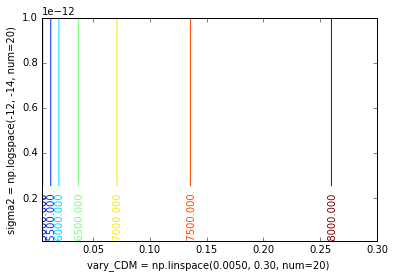

In [232]:
vary_CDM = np.linspace(0.0050, 0.30, num=20 ) #set default num = 20
sigma2 = np.logspace(-12, -14, num=20) #set default num = 30

xxx = vary_CDM
yyy = sigma2

zzz = np.array([[LogLikehood_wNoise_1e12_Contour(np.asarray(i), np.asarray(j)) for i in xxx] for j in yyy])

zzzreshaped = zzz.reshape(20,20)

plt.figure()
CS = plt.contour(xxx, yyy, zzzreshaped)
plt.clabel(CS, inline=1, fontsize=10)
plt.xlabel("vary_CDM = np.linspace(0.0050, 0.30, num=20) ")
plt.ylabel("sigma2 = np.logspace(-12, -14, num=20)")
pb.show()

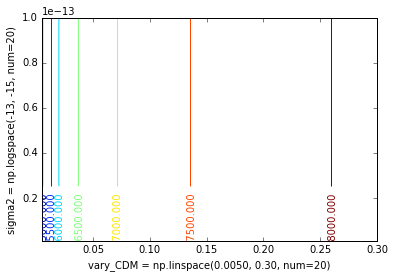

In [233]:
vary_CDM = np.linspace(0.0050, 0.30, num=20 ) #set default num = 20
sigma2 = np.logspace(-13, -15, num=20) #set default num = 30

xxx = vary_CDM
yyy = sigma2

zzz = np.array([[LogLikehood_wNoise_1e12_Contour(np.asarray(i), np.asarray(j)) for i in xxx] for j in yyy])

zzzreshaped = zzz.reshape(20,20)

plt.figure()
CS = plt.contour(xxx, yyy, zzzreshaped)
plt.clabel(CS, inline=1, fontsize=10)
plt.xlabel("vary_CDM = np.linspace(0.0050, 0.30, num=20)")
plt.ylabel("sigma2 = np.logspace(-13, -15, num=20)")
pb.show()

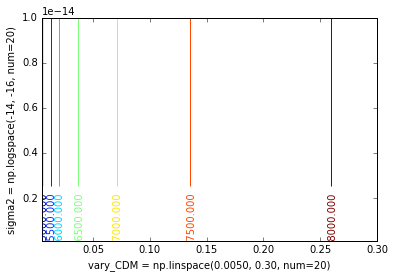

In [234]:
vary_CDM = np.linspace(0.0050, 0.30, num=20 ) #set default num = 20
sigma2 = np.logspace(-14, -16, num=20) #set default num = 30

xxx = vary_CDM
yyy = sigma2

zzz = np.array([[LogLikehood_wNoise_1e12_Contour(np.asarray(i), np.asarray(j)) for i in xxx] for j in yyy])

zzzreshaped = zzz.reshape(20,20)

plt.figure()
CS = plt.contour(xxx, yyy, zzzreshaped)
plt.clabel(CS, inline=1, fontsize=10)
plt.xlabel("vary_CDM = np.linspace(0.0050, 0.30, num=20)")
plt.ylabel("sigma2 = np.logspace(-14, -16, num=20)")
pb.show()

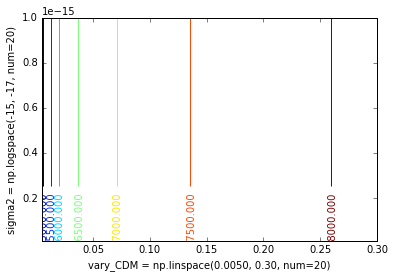

In [235]:
vary_CDM = np.linspace(0.0050, 0.30, num=20 ) #set default num = 20
sigma2 = np.logspace(-15, -17, num=20) #set default num = 30

xxx = vary_CDM
yyy = sigma2

zzz = np.array([[LogLikehood_wNoise_1e12_Contour(np.asarray(i), np.asarray(j)) for i in xxx] for j in yyy])

zzzreshaped = zzz.reshape(20,20)

plt.figure()
CS = plt.contour(xxx, yyy, zzzreshaped)
plt.clabel(CS, inline=1, fontsize=10)
plt.xlabel("vary_CDM = np.linspace(0.0050, 0.30, num=20)")
plt.ylabel("sigma2 = np.logspace(-15, -17, num=20)")
pb.show()

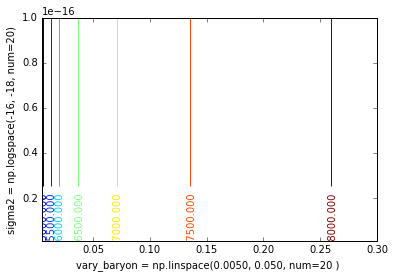

In [236]:
vary_CDM = np.linspace(0.0050, 0.30, num=20 ) #set default num = 20
sigma2 = np.logspace(-16, -18, num=20) #set default num = 30

xxx = vary_CDM
yyy = sigma2

zzz = np.array([[LogLikehood_wNoise_1e12_Contour(np.asarray(i), np.asarray(j)) for i in xxx] for j in yyy])

zzzreshaped = zzz.reshape(20,20)

plt.figure()
CS = plt.contour(xxx, yyy, zzzreshaped)
plt.clabel(CS, inline=1, fontsize=10)
plt.xlabel("vary_baryon = np.linspace(0.0050, 0.050, num=20 ) ")
plt.ylabel("sigma2 = np.logspace(-16, -18, num=20)")
pb.show()

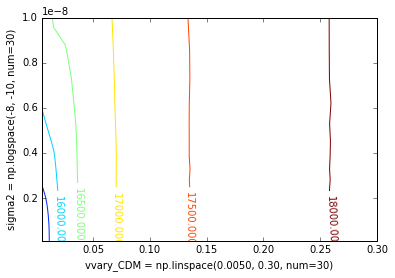

In [237]:
vary_CDM = np.linspace(0.0050, 0.30, num=30 ) #set default num = 20
sigma2 = np.logspace(-8, -10, num=30) #set default num = 30

xxx = vary_CDM
yyy = sigma2

zzz = np.array([[LogLikehood_wNoise_1e12_Contour(np.asarray(i), np.asarray(j)) for i in xxx] for j in yyy])

zzzreshaped = zzz.reshape(30,30)

plt.figure()
CS = plt.contour(xxx, yyy, zzzreshaped)
plt.clabel(CS, inline=1, fontsize=10)
plt.xlabel("vvary_CDM = np.linspace(0.0050, 0.30, num=30)")
plt.ylabel("sigma2 = np.logspace(-8, -10, num=30)")
pb.show()

In [238]:
#
# Hold sigma^2 constant, vary C3
#
# Begin at sigma^2 = 1e-5
#
print(vary_CDM)

[ 0.005       0.01517241  0.02534483  0.03551724  0.04568966  0.05586207
  0.06603448  0.0762069   0.08637931  0.09655172  0.10672414  0.11689655
  0.12706897  0.13724138  0.14741379  0.15758621  0.16775862  0.17793103
  0.18810345  0.19827586  0.20844828  0.21862069  0.2287931   0.23896552
  0.24913793  0.25931034  0.26948276  0.27965517  0.28982759  0.3       ]


[ 0.005       0.01102041  0.01704082  0.02306122  0.02908163  0.03510204
  0.04112245  0.04714286  0.05316327  0.05918367  0.06520408  0.07122449
  0.0772449   0.08326531  0.08928571  0.09530612  0.10132653  0.10734694
  0.11336735  0.11938776  0.12540816  0.13142857  0.13744898  0.14346939
  0.1494898   0.1555102   0.16153061  0.16755102  0.17357143  0.17959184
  0.18561224  0.19163265  0.19765306  0.20367347  0.20969388  0.21571429
  0.22173469  0.2277551   0.23377551  0.23979592  0.24581633  0.25183673
  0.25785714  0.26387755  0.26989796  0.27591837  0.28193878  0.28795918
  0.29397959  0.3       ]


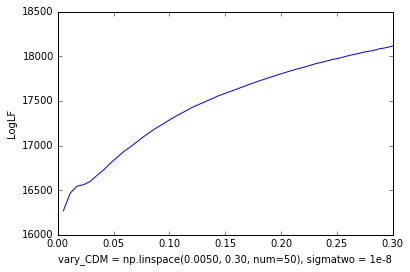

In [239]:
tempp = (1e6)*patch # multiply CMB maps by 1e6

def LogLikehood_wNoise_constant(param, sig):
    # param is our parameter, C_3
    Sij = param[:, None, None] * correctmatrix[None, :, :]
    newSij = (1e12)*Sij   # multiply S_ij by 1e12
    Nij = sig * id_mat[None, :, :]
    newNij = (1e12)*Nij
    # Format 7/4pi * param * P_3(M) where param is the parameter we vary, C_l
    # Sij.shape = (20, 3072, 3072)
    Cij = newSij + newNij
    #invCij = np.linalg.inv(Cij)
    logdetC = np.linalg.slogdet(Cij)  # returns sign and determinant; use logdetC[1]
    # model_fit_terms = m^T C^-1 m
    #
    # model_fit_terms = np.array([np.dot(tempval.T , np.dot(invCij[i] , tempval) ) 
    # for i in range(invCij.shape[0])])
    #
    model_fit_terms = np.array([np.dot(tempp.T , np.linalg.solve(Cij[i], tempp) ) for i in range(Cij.shape[0]) ]) 
    return model_fit_terms + logdetC[1] + Npix2pi


vary_CDM = np.linspace(0.0050, 0.30, num=50 ) #set default num = 20
sigmatwo = 1e-8
print(vary_CDM)

xx = vary_CDM
yy = LogLikehood_wNoise_constant(vary_CDM, sigmatwo)

plt.figure()
CS = plt.plot(xx, yy)
plt.xlabel("vary_CDM = np.linspace(0.0050, 0.30, num=50), sigmatwo = 1e-8")
plt.ylabel("LogLF")
pb.show()


[ 0.005       0.01102041  0.01704082  0.02306122  0.02908163  0.03510204
  0.04112245  0.04714286  0.05316327  0.05918367  0.06520408  0.07122449
  0.0772449   0.08326531  0.08928571  0.09530612  0.10132653  0.10734694
  0.11336735  0.11938776  0.12540816  0.13142857  0.13744898  0.14346939
  0.1494898   0.1555102   0.16153061  0.16755102  0.17357143  0.17959184
  0.18561224  0.19163265  0.19765306  0.20367347  0.20969388  0.21571429
  0.22173469  0.2277551   0.23377551  0.23979592  0.24581633  0.25183673
  0.25785714  0.26387755  0.26989796  0.27591837  0.28193878  0.28795918
  0.29397959  0.3       ]


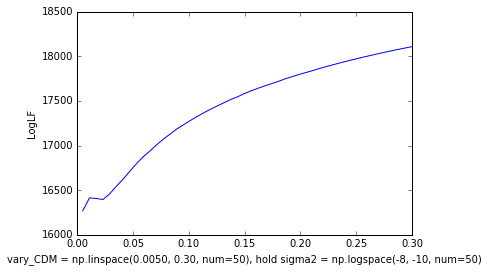

In [240]:
tempp = (1e6)*patch # multiply CMB maps by 1e6

def LogLikehood_wNoise_constant(param, sig):
    # param is our parameter, C_3
    Sij = param[:, None, None] * correctmatrix[None, :, :]
    newSij = (1e12)*Sij   # multiply S_ij by 1e12
    Nij = sig[:, None, None] * id_mat[None, :, :]
    newNij = (1e12)*Nij
    # Format 7/4pi * param * P_3(M) where param is the parameter we vary, C_l
    # Sij.shape = (20, 3072, 3072)
    Cij = newSij + newNij
    #invCij = np.linalg.inv(Cij)
    logdetC = np.linalg.slogdet(Cij)  # returns sign and determinant; use logdetC[1]
    # model_fit_terms = m^T C^-1 m
    #
    # model_fit_terms = np.array([np.dot(tempval.T , np.dot(invCij[i] , tempval) ) 
    # for i in range(invCij.shape[0])])
    #
    model_fit_terms = np.array([np.dot(tempp.T , np.linalg.solve(Cij[i], tempp) ) for i in range(Cij.shape[0]) ]) 
    return model_fit_terms + logdetC[1] + Npix2pi

vary_CDM = np.linspace(0.0050, 0.30, num=50 ) #set default num = 20
sigmatwo = np.logspace(-8, -10, num=50)
print(vary_CDM)

xx = vary_CDM
yy = LogLikehood_wNoise_constant(vary_CDM, sigmatwo)

plt.figure()
CS = plt.plot(xx, yy)
plt.xlabel("vary_CDM = np.linspace(0.0050, 0.30, num=50), hold sigma2 = np.logspace(-8, -10, num=50)")
plt.ylabel("LogLF")
pb.show()

[ 0.005       0.01102041  0.01704082  0.02306122  0.02908163  0.03510204
  0.04112245  0.04714286  0.05316327  0.05918367  0.06520408  0.07122449
  0.0772449   0.08326531  0.08928571  0.09530612  0.10132653  0.10734694
  0.11336735  0.11938776  0.12540816  0.13142857  0.13744898  0.14346939
  0.1494898   0.1555102   0.16153061  0.16755102  0.17357143  0.17959184
  0.18561224  0.19163265  0.19765306  0.20367347  0.20969388  0.21571429
  0.22173469  0.2277551   0.23377551  0.23979592  0.24581633  0.25183673
  0.25785714  0.26387755  0.26989796  0.27591837  0.28193878  0.28795918
  0.29397959  0.3       ]


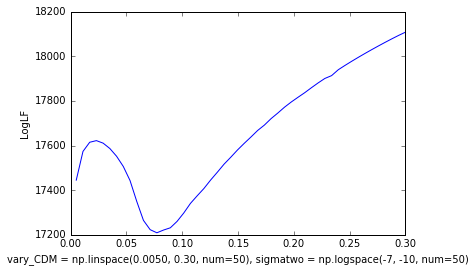

In [241]:
tempp = (1e6)*patch # multiply CMB maps by 1e6

def LogLikehood_wNoise_constant(param, sig):
    # param is our parameter, C_3
    Sij = param[:, None, None] * correctmatrix[None, :, :]
    newSij = (1e12)*Sij   # multiply S_ij by 1e12
    Nij = sig[:, None, None] * id_mat[None, :, :]
    newNij = (1e12)*Nij
    # Format 7/4pi * param * P_3(M) where param is the parameter we vary, C_l
    # Sij.shape = (20, 3072, 3072)
    Cij = newSij + newNij
    #invCij = np.linalg.inv(Cij)
    logdetC = np.linalg.slogdet(Cij)  # returns sign and determinant; use logdetC[1]
    # model_fit_terms = m^T C^-1 m
    #
    # model_fit_terms = np.array([np.dot(tempval.T , np.dot(invCij[i] , tempval) ) 
    # for i in range(invCij.shape[0])])
    #
    model_fit_terms = np.array([np.dot(tempp.T , np.linalg.solve(Cij[i], tempp) ) for i in range(Cij.shape[0]) ]) 
    return model_fit_terms + logdetC[1] + Npix2pi


vary_CDM = np.linspace(0.0050, 0.30, num=50 ) #set default num = 20
sigmatwo = np.logspace(-7, -10, num=50)
print(vary_CDM)

xx = vary_CDM
yy = LogLikehood_wNoise_constant(vary_CDM, sigmatwo)

plt.figure()
CS = plt.plot(xx, yy)
plt.xlabel("vary_CDM = np.linspace(0.0050, 0.30, num=50), sigmatwo = np.logspace(-7, -10, num=50)")
plt.ylabel("LogLF")
pb.show()

[ 0.005       0.01102041  0.01704082  0.02306122  0.02908163  0.03510204
  0.04112245  0.04714286  0.05316327  0.05918367  0.06520408  0.07122449
  0.0772449   0.08326531  0.08928571  0.09530612  0.10132653  0.10734694
  0.11336735  0.11938776  0.12540816  0.13142857  0.13744898  0.14346939
  0.1494898   0.1555102   0.16153061  0.16755102  0.17357143  0.17959184
  0.18561224  0.19163265  0.19765306  0.20367347  0.20969388  0.21571429
  0.22173469  0.2277551   0.23377551  0.23979592  0.24581633  0.25183673
  0.25785714  0.26387755  0.26989796  0.27591837  0.28193878  0.28795918
  0.29397959  0.3       ]


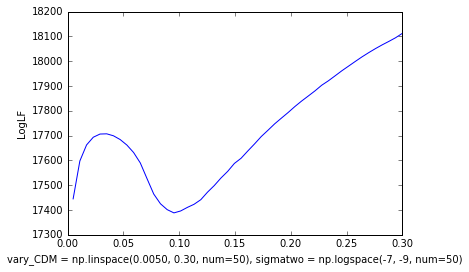

In [242]:
tempp = (1e6)*patch # multiply CMB maps by 1e6

def LogLikehood_wNoise_constant(param, sig):
    # param is our parameter, C_3
    Sij = param[:, None, None] * correctmatrix[None, :, :]
    newSij = (1e12)*Sij   # multiply S_ij by 1e12
    Nij = sig[:, None, None] * id_mat[None, :, :]
    newNij = (1e12)*Nij
    # Format 7/4pi * param * P_3(M) where param is the parameter we vary, C_l
    # Sij.shape = (20, 3072, 3072)
    Cij = newSij + newNij
    #invCij = np.linalg.inv(Cij)
    logdetC = np.linalg.slogdet(Cij)  # returns sign and determinant; use logdetC[1]
    # model_fit_terms = m^T C^-1 m
    #
    # model_fit_terms = np.array([np.dot(tempval.T , np.dot(invCij[i] , tempval) ) 
    # for i in range(invCij.shape[0])])
    #
    model_fit_terms = np.array([np.dot(tempp.T , np.linalg.solve(Cij[i], tempp) ) for i in range(Cij.shape[0]) ]) 
    return model_fit_terms + logdetC[1] + Npix2pi


vary_CDM = np.linspace(0.0050, 0.30, num=50) #set default num = 20
sigmatwo = np.logspace(-7, -9, num=50)
print(vary_CDM)

xx = vary_CDM
yy = LogLikehood_wNoise_constant(vary_CDM, sigmatwo)

plt.figure()
CS = plt.plot(xx, yy)
plt.xlabel("vary_CDM = np.linspace(0.0050, 0.30, num=50), sigmatwo = np.logspace(-7, -9, num=50)")
plt.ylabel("LogLF")
pb.show()

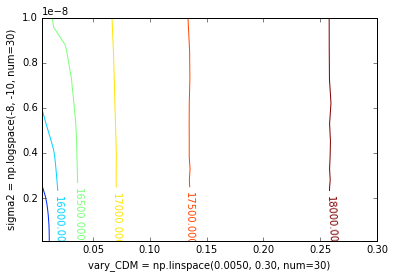

In [243]:
vary_CDM = np.linspace(0.0050, 0.30, num=30) #set default num = 20
sigma2 = np.logspace(-8, -10, num=30) #set default num = 30

xxx = vary_CDM
yyy = sigma2

zzz = np.array([[LogLikehood_wNoise_1e12_Contour(np.asarray(i), np.asarray(j)) for i in xxx] for j in yyy])

zzzreshaped = zzz.reshape(30,30)

plt.figure()
CS = plt.contour(xxx, yyy, zzzreshaped)
plt.clabel(CS, inline=1, fontsize=10)
plt.xlabel("vary_CDM = np.linspace(0.0050, 0.30, num=30)")
plt.ylabel("sigma2 = np.logspace(-8, -10, num=30)")
pb.show()